# A1: That’s What I LIKE

Class: AT82.05 Artificial Intelligence: Natural Language Understanding (NLU) 

Taught by: Dr. Chaklam Silpasuwanchai, Todsavad Tangtortan

Semester: Jan 2026


This assignment focuses on creating a system to find similar context in Natural Language Processing. 

The system, deployed on a website, should return the top paragraphs with the most similar context to a given query, such as ”Harry Potter.” 

This task will involve building upon existing code, understanding and implementing word **embedding techniques**, and creating a web interface for the system to deliver the results.

**Deliverables:**

1) The GitHub link containing the jupyter notebook, 
2) a README.md of the github, 
3) and the folder of your web application called ‘app’.


# Task 1. Preparation and Training

Build upon the code discussed in class. Do not use pre-built solutions from the internet.

## 1) Read and understand the Word2Vec1 and GloVe2 papers.

- [Word2Vec1](https://arxiv.org/pdf/1301.3781.pdf)

- [GloVe2](https://aclanthology.org/D14-1162.pdf)



### Steps followed:
1. Download the news data from nltk.
2. Preprocess the news data (tokenize, clean)
3. Train Word2Vec and GloVe models on this corpus

## 2) Modify the Word2Vec (with & without negative sampling) and GloVe from the lab lecture (3 points)

##### 2.1) Train using a real-world corpus (suggest to categories news from nltk datset). Ensure to source this dataset from reputable public databases or repositories. It is imperative to give proper credit to the dataset source in your documentation.

>> Refer https://www.nltk.org/data.html 
>> Refer https://www.nltk.org/howto/corpus.html

Python interactive code:

```python
    import nltk
    nltk.download() # this will download ALL NLTK data, it will take forever!
    # define corpus
    nltk.download('brown') # download corpus from brown
    # If you do not provide any location to download, it will download in homedirectory 
    # eg. ~/nlkt_data/brown.zip
```

As per suggestion, this assignment will use news categories from Brown corpus

##### Initialization and download corpus from NLTK site

In [105]:
# for numerical computations
import numpy as np
# neural network libraries
import torch
import torch.nn as nn
import torch.optim as optim
# for plotting
import matplotlib.pyplot as plt

In [106]:
np.__version__, torch.__version__

('2.4.1', '2.9.1')

In [107]:
import matplotlib
matplotlib.__version__

'3.10.8'

In [108]:
# Define custom data folder
import os
from pathlib import Path

notebook_dir = os.path.dirname(os.path.abspath('__file__'))
data_folder = Path(notebook_dir).parent / "data"
data_folder.mkdir(parents=True, exist_ok=True)
str(data_folder)


'/Users/sushmi/dev/nlp/assignment-npl/A1/data'

In [109]:
# Download popular NLP datasets using NLTK from Brown corpus
import nltk
# Add the custom data folder to NLTK data path
nltk.data.path.append(str(data_folder))
nltk.download('brown')

[nltk_data] Downloading package brown to /Users/sushmi/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [110]:
# Get news from brown corpus
from nltk.corpus import brown

# List all available categories
print("Available categories in Brown corpus:")
print(brown.categories())

# Get only news articles
print("\nExtracting news articles from Brown corpus...")
# Create corpus as list of sentences (each sentence is a list of words)
corpus = brown.sents(categories='news')
print(f"Loaded {len(corpus)} sentences from news category")
print(f"Sample sentence: {corpus[0][:10]}...")  # Show first 10 words of first sentence

print("\nFirst sentence in the corpus:")
print(' '.join(corpus[0]))

Available categories in Brown corpus:
['adventure', 'belles_lettres', 'editorial', 'fiction', 'government', 'hobbies', 'humor', 'learned', 'lore', 'mystery', 'news', 'religion', 'reviews', 'romance', 'science_fiction']

Extracting news articles from Brown corpus...
Loaded 4623 sentences from news category
Sample sentence: ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of']...

First sentence in the corpus:
The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place .


In [111]:
# Trim down vocab size train model faster, we will limit the corpus size
max_corpus_size = 500  # limit to first 500 sentences
full_corpus = corpus
corpus = corpus[:max_corpus_size]
print(f"Using first {len(corpus)} sentences for training.")

Using first 500 sentences for training.


In [112]:
# set default window size = 2
DEFAULT_WINDOW_SIZE = 2 
DEFAULT_WINDOW_SIZE

2

In [113]:
DEFAULT_EMBEDDING_SIZE = 2
DEFAULT_EMBEDDING_SIZE

2

In [114]:
DEFAULT_EPOCH_NUMS = 10000
DEFAULT_EPOCH_NUMS

10000

In [115]:
DEFAULT_BATCH_SIZE = 2
DEFAULT_BATCH_SIZE

2

In [116]:
# Sentences are already tokenized in the Brown corpus
# Find unique words in the corpus
# get word sequences 
flatten = lambda l: [item for sublist in l for item in sublist]
# get unique words and 
vocab = list(set(flatten(corpus))) # vocabs = all unique words in the corpus
# Add 'Unknown : <UNK>' to handle missing words
vocab.append('<UNK>')
vocab[:10]  # Show first 10 unique words

['supermarkets',
 '9th',
 'presented',
 'lever',
 'waged',
 'attempt',
 'establishing',
 'letterman',
 'request',
 'hold']

In [117]:
# Numericalization
# create handy mapping between integers and words
# done by creating dictionary
word2index = {w: i for i, w in enumerate(vocab)}
list(word2index.items())[0:10] # print first 10 entries from word2index

[('supermarkets', 0),
 ('9th', 1),
 ('presented', 2),
 ('lever', 3),
 ('waged', 4),
 ('attempt', 5),
 ('establishing', 6),
 ('letterman', 7),
 ('request', 8),
 ('hold', 9)]

In [118]:
# create reverse mapping, index to word
index2word = {v:k for k, v in word2index.items()} 
list(index2word.items())[:10] # print first 10 entries from index2word

[(0, 'supermarkets'),
 (1, '9th'),
 (2, 'presented'),
 (3, 'lever'),
 (4, 'waged'),
 (5, 'attempt'),
 (6, 'establishing'),
 (7, 'letterman'),
 (8, 'request'),
 (9, 'hold')]

In [119]:
# vocabulary size
vocab_size = len(vocab)
vocab_size

2947

##### 2.2) Create a function that allows dynamic modification of the window size during training. Use a window size of 2 as default


In [120]:
# create pairs of center word, and context word 
# context words are other words on left and right of the center word
# This is only for reference , not used in anywhere
def random_batch_class(batch_size, word_sequence):
    
    # Make skip gram of window size 1
    skip_grams = []
    # loop each word sequence
    for sent in corpus:
        # we starts from 1 because 0 has no context or complete context (left and right)
        # we stop at second last for the same reason - has no complete context
        for i in range(1, len(sent) - 1):
            center = word2index[sent[i]] # center word in integers using word2index
            context = [word2index[sent[i - 1]], word2index[sent[i + 1]]] # context words in integers using word2index
            for w in context:
                skip_grams.append([center, w]) #center, context1;   center, context2

    random_inputs = []
    random_labels = []
    #randomly pick without replacement
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) 
        
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels)

In [121]:
def random_batch(batch_size, corpus, window_size = 2):
    # Make skip gram of custom size window: 2 context words on each side
    skip_grams = []

    for sent in corpus:
         # we starts from 2(window size) because 0 and 1 has no context or complete context (left and right)
        # we stop at last window-size-th element for the same reason - has no complete context
        for center_index in range(window_size, len(sent) - window_size):
            center = word2index[sent[center_index]]
            context = []
            count = window_size # count of context words to pick on the left and right
            while count > 0:
                # for default window, it will get the left most and right most word
                # then the second left most and second right most word
                context.append(word2index[sent[center_index - count]])
                context.append(word2index[sent[center_index + count]])
                count -= 1

            for word in context:
                skip_grams.append((center, word))

    random_inputs = []
    random_labels = []
    #randomly pick without replacement
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) 
    
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels)

In [122]:
random_batch(batch_size=2, corpus=corpus, window_size=2)

(array([[2180],
        [ 641]]),
 array([[2733],
        [ 100]]))

#### Testing the method

In [123]:
input_batch, target_batch = random_batch(DEFAULT_WINDOW_SIZE, corpus)

input_batch, target_batch

(array([[1858],
        [2386]]),
 array([[1042],
        [1333]]))

In [124]:
input_batch.shape, target_batch.shape

((2, 1), (2, 1))

# Task 2. Model Comparison and Analysis

## 1) Compare Skip-gram, Skip-gram negative sampling, GloVe models on training loss, training time. (1 points)


### a) Skip-gram Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [125]:
# Model: Skipgram
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(Skipgram,self).__init__()
        self.name = "Skipgram"
        self.embedding_v = nn.Embedding(vocab_size, emb_size)
        self.embedding_u = nn.Embedding(vocab_size, emb_size)
    
    def forward(self, center_words, target_words, all_vocabs):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        all_embeds    = self.embedding_u(all_vocabs) #   [batch_size, voc_size, emb_size]
        
        scores      = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, voc_size, emb_size] @ [batch_size, emb_size, 1] = [batch_size, voc_size, 1] = [batch_size, voc_size]

        # log-softmax : convert raw numbers into probabilities (0 to 1, sum to 1)
        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))) 
        # scalar (loss must be scalar)    
            
        return nll # negative loss in log likelihood

# embedding shape => batch_size, em

In [126]:
# Training skipgram
batch_size     = DEFAULT_BATCH_SIZE # mini-batch size
embed_size     = DEFAULT_EMBEDDING_SIZE #so we can later plot
skipgram_model = Skipgram(vocab_size, embed_size)



##### Training Skipgram model
Note: Keeping training steps separate as skipgram negative requires negative samples

** Towards the end, we will combine training steps into one method

In [127]:
vocab[:10]

['supermarkets',
 '9th',
 'presented',
 'lever',
 'waged',
 'attempt',
 'establishing',
 'letterman',
 'request',
 'hold']

In [128]:
# Prepare all vocabs - convert string vocabs to integers
voc_size   = len(vocab)
print("Vocal size: " , voc_size)

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)


Vocal size:  2947


In [129]:
all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, voc_size)
all_vocabs

tensor([[   0,    1,    2,  ..., 2944, 2945, 2946],
        [   0,    1,    2,  ..., 2944, 2945, 2946]])

In [130]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [131]:
print(f"Model: Skipgram, voc_size: {voc_size}, embed_size: {embed_size}")
skipgram_model = Skipgram(voc_size, embed_size)

Model: Skipgram, voc_size: 2947, embed_size: 2


In [132]:
import time

losses_log = {}
elapsed_log = {} # each item is measure of 1000 epoch time

def train_model(model, optimizer):
    num_epochs = DEFAULT_EPOCH_NUMS
    start = time.time()
    # Initialize empty list for to log metrics model
    losses_log[model.name] = []      
    elapsed_log[model.name] = []

    for epoch in range(num_epochs):

        #get batch
        input_batch, label_batch = random_batch(batch_size, corpus)
        input_tensor = torch.LongTensor(input_batch)
        label_tensor = torch.LongTensor(label_batch)

        loss = np.inf # define default as zero

        #predict
        loss = model(input_tensor, label_tensor, all_vocabs)
        # log losses
        losses_log[model.name].append(loss)
        
        #backprogate
        optimizer.zero_grad()
        loss.backward()
        
        #update alpha
        optimizer.step()

        end = time.time()

        #print the loss
        if (epoch + 1) % 1000 == 0:
            end = time.time()
            elapsed_s = end - start
            # log elapsed time in seconds
            elapsed_log[model.name].append(elapsed_s)
            epoch_mins, epoch_secs = epoch_time(start, end)
            start = end
            print(f"{model.name:<15} | Epoch {epoch+1:6.0f} | Loss: {loss:2.6f} | Time: {epoch_mins}m {epoch_secs}s | Elapsed in ms: {elapsed_s}")

In [133]:
# Define single optimizer for all models
# learning rate 0.001 cause loss flutuate over 9 to 12. To stabilize, we reduce to 0.0001 => 0.00001
LEARNING_RATE_SG = 0.00001
optimizer = optim.Adam(skipgram_model.parameters(), lr=LEARNING_RATE_SG)

train_model(skipgram_model, optimizer)

Skipgram        | Epoch   1000 | Loss: 8.894298 | Time: 0m 10s | Elapsed in ms: 10.867300033569336
Skipgram        | Epoch   2000 | Loss: 9.024576 | Time: 0m 10s | Elapsed in ms: 10.891300916671753
Skipgram        | Epoch   3000 | Loss: 8.153348 | Time: 0m 10s | Elapsed in ms: 10.908501386642456
Skipgram        | Epoch   4000 | Loss: 9.331032 | Time: 0m 10s | Elapsed in ms: 10.78635859489441
Skipgram        | Epoch   5000 | Loss: 7.250352 | Time: 0m 11s | Elapsed in ms: 11.019287109375
Skipgram        | Epoch   6000 | Loss: 11.570881 | Time: 0m 11s | Elapsed in ms: 11.30958104133606
Skipgram        | Epoch   7000 | Loss: 8.671612 | Time: 0m 10s | Elapsed in ms: 10.812901258468628
Skipgram        | Epoch   8000 | Loss: 8.461798 | Time: 0m 10s | Elapsed in ms: 10.99042272567749
Skipgram        | Epoch   9000 | Loss: 8.084927 | Time: 0m 11s | Elapsed in ms: 11.34327507019043
Skipgram        | Epoch  10000 | Loss: 8.372346 | Time: 0m 11s | Elapsed in ms: 11.73862099647522


Plotting the embeddings

In [134]:
#let's write a function to get embedding given a word
def get_embed(word, custom_model):
    # Handle missing words
    if word not in word2index:
        word = '<UNK>'
    
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = custom_model.embedding_v(id_tensor)
    u_embed = custom_model.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

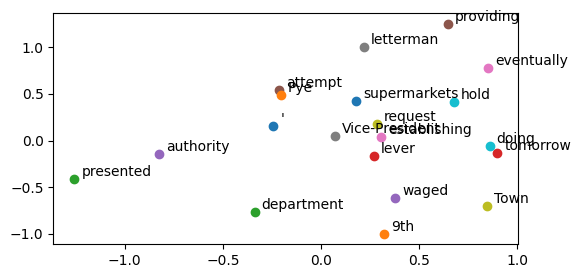

In [135]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word, skipgram_model)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

### b) Skipgram NEGATIVE Sampling Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

#### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

Where:

- $U(w)$ frequency of word w in corpus (unigram probability)
- $3/4$ = smoothing exponent (makes common words less dominant)
- $Z$ = normalization factor, a normalization constant that ensures probabilities sum to 1.


In [136]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.name = "SkipgramNegSampling"
        self.embedding_v = nn.Embedding(vocab_size, emb_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, emb_size) # out embedding
        self.logsigmoid = nn.LogSigmoid()
                    
    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        neg_embeds    = -self.embedding_u(negative_words) # [batch_size, num_neg, emb_size]
        
        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        negative_score = neg_embeds.bmm(center_embeds.transpose(1, 2))
        #[batch_size, k, emb_size] @ [batch_size, emb_size, 1] = [batch_size, k, 1]
        
        loss = self.logsigmoid(positive_score) + torch.sum(self.logsigmoid(negative_score), 1)
                
        return -torch.mean(loss)
    
    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        
        return embeds

In [137]:
Z = 0.001

In [138]:
from collections import Counter

word_count = Counter(flatten(corpus))
num_total_words = sum([c for w, c in word_count.items()])

word_count.most_common(10), num_total_words

([('the', 697),
  (',', 457),
  ('.', 439),
  ('of', 371),
  ('to', 307),
  ('a', 230),
  ('in', 212),
  ('and', 198),
  ('``', 128),
  ('for', 126)],
 11711)

In [139]:
# Prepare unigram table for negative sampling
unigram_table = []

for word in vocab:
    unigram_table.extend([word] * int(((word_count[word]/num_total_words)**0.75)/Z))

unigram_table[0:10]

['supermarkets',
 'attempt',
 'request',
 'hold',
 'hold',
 "'",
 "'",
 "'",
 'department',
 'authority']

In [140]:
Counter(unigram_table).most_common(10)

[('the', 120),
 (',', 87),
 ('.', 85),
 ('of', 75),
 ('to', 65),
 ('a', 52),
 ('in', 49),
 ('and', 46),
 ('``', 33),
 ("''", 33)]

In [141]:
# Prepare negative sampling method for Skipgram negative sample model
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).view(1, -1))
    return torch.cat(neg_samples)

#### Train Skipgram Negative Sampling model

In [142]:
batch_size     = DEFAULT_WINDOW_SIZE
embedding_size = DEFAULT_EMBEDDING_SIZE #so we can later plot
print(f"Mode: Skipgram Negative Sample, voc_size: {voc_size}, embed_size: {embed_size}")
skip_neg_model = SkipgramNegSampling(voc_size, embedding_size)
num_neg        = 10 # num of negative sampling
LEARNING_RATE_SGNEG = 0.001

optimizer = optim.Adam(skip_neg_model.parameters(), lr=LEARNING_RATE_SGNEG)

Mode: Skipgram Negative Sample, voc_size: 2947, embed_size: 2


In [143]:
# Train Skipgram NEG model
import time

# Training
num_epochs = 10000 #DEFAULT_EPOCH_NUMS #5000
 # Initialize empty list for each model
losses_log[skip_neg_model.name] = []     
elapsed_log[skip_neg_model.name] = []

for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch = random_batch(batch_size, corpus)
    
    #input_batch: [batch_size, 1]
    input_batch = torch.LongTensor(input_batch)
    
    #target_batch: [batch_size, 1]
    target_batch = torch.LongTensor(target_batch)
    
    #negs_batch:   [batch_size, num_neg]
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)
    
    optimizer.zero_grad()
        
    loss = skip_neg_model(input_batch, target_batch, negs_batch)
    # log loss
    losses_log[skip_neg_model.name].append(loss)

    
    end = time.time()
    # log elapsed time
    elapsed_log[skip_neg_model.name].append(end - start)
    
    epoch_mins, epoch_secs = epoch_time(start, end)
    
    loss.backward()
    optimizer.step()

    #print the loss
    if (epoch + 1) % 1000 == 0:
        end = time.time()
        elapsed_s = end - start
        # log elapsed time in seconds
        elapsed_log[skip_neg_model.name].append(elapsed_s)
        epoch_mins, epoch_secs = epoch_time(start, end)
        start = end
        print(f"{skip_neg_model.name:<15} | Epoch {epoch+1:6.0f} | Loss: {loss:2.6f} | Time: {epoch_mins}m {epoch_secs}s | Elapsed in s: {elapsed_s}")

SkipgramNegSampling | Epoch   1000 | Loss: 9.635357 | Time: 0m 0s | Elapsed in s: 0.010955810546875
SkipgramNegSampling | Epoch   2000 | Loss: 8.305322 | Time: 0m 0s | Elapsed in s: 0.010931968688964844
SkipgramNegSampling | Epoch   3000 | Loss: 12.588873 | Time: 0m 0s | Elapsed in s: 0.010948896408081055
SkipgramNegSampling | Epoch   4000 | Loss: 8.479225 | Time: 0m 0s | Elapsed in s: 0.010933876037597656
SkipgramNegSampling | Epoch   5000 | Loss: 7.661790 | Time: 0m 0s | Elapsed in s: 0.011108160018920898
SkipgramNegSampling | Epoch   6000 | Loss: 7.134871 | Time: 0m 0s | Elapsed in s: 0.01286768913269043
SkipgramNegSampling | Epoch   7000 | Loss: 8.893358 | Time: 0m 0s | Elapsed in s: 0.011333227157592773
SkipgramNegSampling | Epoch   8000 | Loss: 8.747946 | Time: 0m 0s | Elapsed in s: 0.01108098030090332
SkipgramNegSampling | Epoch   9000 | Loss: 6.682693 | Time: 0m 0s | Elapsed in s: 0.012829065322875977
SkipgramNegSampling | Epoch  10000 | Loss: 6.594890 | Time: 0m 0s | Elapsed i

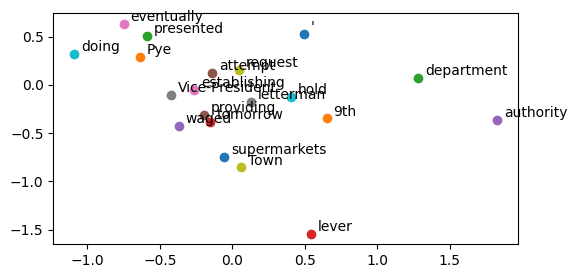

In [144]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word, skip_neg_model)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

### Glove Model

$$ J = \sum_{i,j=1}^{V} f(X_{ij}) \left( w_i^T \tilde{w}_j + b_i + \tilde{b}_j - \log X_{ij} \right)^2 $$

In [145]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        self.name = "GloVe"
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

#### Build co-occurance Matrix X

In [146]:
from collections import Counter

X_i = Counter(flatten(corpus)) # X_i
X_i

def get_skipgram(window_size = 2):
    # Make skip gram of custom size window
    skipgrams = []

    for sent in corpus:
        for center_index in range(window_size, len(sent) - window_size):
            target = sent[center_index]
            context = []
            count = window_size # count of context words to pick on the left and right
            while count > 0:
                # for default window, it will get the left most and right most word
                # then the second left most and second right most word
                context.append(sent[center_index - count])
                context.append(sent[center_index + count])
                count -= 1

            for word in context:
                skipgrams.append((target, word))
            
    return skipgrams

In [147]:
get_skipgram(window_size=2)[:10]

[('County', 'The'),
 ('County', 'Jury'),
 ('County', 'Fulton'),
 ('County', 'Grand'),
 ('Grand', 'Fulton'),
 ('Grand', 'said'),
 ('Grand', 'County'),
 ('Grand', 'Jury'),
 ('Jury', 'County'),
 ('Jury', 'Friday')]

In [148]:
skipgrams = get_skipgram(window_size=2)
X_ik_skipgram = Counter(skipgrams) # Co-occurece in window size 1
X_ik_skipgram

Counter({('the', 'of'): 192,
         ('of', 'the'): 188,
         ('the', ','): 95,
         (',', 'the'): 95,
         ('to', 'the'): 92,
         ('the', 'to'): 92,
         ('in', 'the'): 87,
         ('the', 'in'): 86,
         ('a', 'of'): 51,
         ('of', 'a'): 51,
         (',', ','): 48,
         (',', 'and'): 46,
         ('and', ','): 46,
         (',', 'said'): 45,
         ('said', ','): 41,
         ('that', 'the'): 40,
         ('the', 'that'): 40,
         ('the', 'and'): 40,
         ('and', 'the'): 40,
         ('of', ','): 39,
         (',', 'of'): 39,
         ('the', 'for'): 38,
         ('for', 'the'): 37,
         ('a', ','): 36,
         (',', 'a'): 36,
         ('on', 'the'): 35,
         ('the', 'on'): 35,
         ('he', ','): 35,
         ('to', 'a'): 32,
         ('he', 'said'): 32,
         (',', 'he'): 32,
         ('a', 'to'): 31,
         ('the', '.'): 31,
         ("''", ','): 28,
         (',', "''"): 28,
         ('be', 'would'): 27,
         ('th

#### Weighing Function
GloVe includes a weighting function to scale down too frequent words.

<img src = "../img/glove_weighting_func.png" width=400>

In [149]:
def weighing(w_i, w_j, X_ik):
    
    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        #if not exist, then set to 1 "laplace smoothing"
    except:
        x_ij = 1
        
    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75
    
    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1
    
    return result

In [150]:
from itertools import combinations_with_replacement

X_ik = {} #keeping the co-occurences
weighting_dic = {} #already scale the co-occurences using the weighting function

for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_skipgram.get(bigram):  #if the pair exists in our corpus
        co = X_ik_skipgram[bigram]
        X_ik[bigram] = co + 1 #for stability
        X_ik[(bigram[1], bigram[0])] = co + 1 #basically apple, banana = banana, apple
    else:
        pass
    
    weighting_dic[bigram] = weighing(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighing(bigram[1], bigram[0], X_ik)

In [151]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []
    
    #convert our skipgrams to id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly choose indexes based on batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)
    
    #get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]])
        random_labels.append([skip_grams_id[index][1]])
        #coocs
        pair = skip_grams[index] #e.g., ('banana', 'fruit')
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
    
        #weightings
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

In [152]:
x, y, cooc, weighting = random_batch(DEFAULT_BATCH_SIZE, corpus, skipgrams, X_ik, weighting_dic)
x, y, cooc, weighting 

(array([[ 60],
        [835]]),
 array([[746],
        [825]]),
 array([[0.69314718],
        [0.69314718]]),
 array([[0.05318296],
        [0.05318296]]))

Training the GloVe Model

In [ ]:
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
glove_model          = GloVe(voc_size, embedding_size)

optimizer = optim.Adam(glove_model.parameters(), lr=0.001)

In [154]:
import time

# Training
num_epochs = DEFAULT_EPOCH_NUMS
for epoch in range(num_epochs):
    
    start = time.time()
    losses_log[glove_model.name] = []
    elapsed_log[glove_model.name] = []
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skipgrams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = glove_model(input_batch, target_batch, cooc_batch, weighting_batch)
    losses_log[glove_model.name].append(loss)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

     #print the loss
    if (epoch + 1) % 1000 == 0:
        end = time.time()
        elapsed_s = end - start
        # log elapsed time in ms
        elapsed_log[glove_model.name].append(elapsed_s)
        epoch_mins, epoch_secs = epoch_time(start, end)
        start = end
        print(f"{glove_model.name:<15} | Epoch {epoch+1:6.0f} | Loss: {loss:2.6f} | Time: {epoch_mins}m {epoch_secs}s | Elapsed in ms: {elapsed_s}")


GloVe           | Epoch   1000 | Loss: 15.677116 | Time: 0m 0s | Elapsed in ms: 0.0045239925384521484
GloVe           | Epoch   2000 | Loss: 5.421026 | Time: 0m 0s | Elapsed in ms: 0.0044667720794677734
GloVe           | Epoch   3000 | Loss: 7.121232 | Time: 0m 0s | Elapsed in ms: 0.004445791244506836
GloVe           | Epoch   4000 | Loss: 59.837048 | Time: 0m 0s | Elapsed in ms: 0.004456996917724609
GloVe           | Epoch   5000 | Loss: 4.284197 | Time: 0m 0s | Elapsed in ms: 0.004378318786621094
GloVe           | Epoch   6000 | Loss: 1.220224 | Time: 0m 0s | Elapsed in ms: 0.004297971725463867
GloVe           | Epoch   7000 | Loss: 1.902022 | Time: 0m 0s | Elapsed in ms: 0.0043070316314697266
GloVe           | Epoch   8000 | Loss: 4.749864 | Time: 0m 0s | Elapsed in ms: 0.00425410270690918
GloVe           | Epoch   9000 | Loss: 0.614588 | Time: 0m 0s | Elapsed in ms: 0.004548072814941406
GloVe           | Epoch  10000 | Loss: 2.308846 | Time: 0m 0s | Elapsed in ms: 0.004343032836914

Plotting the embeddings

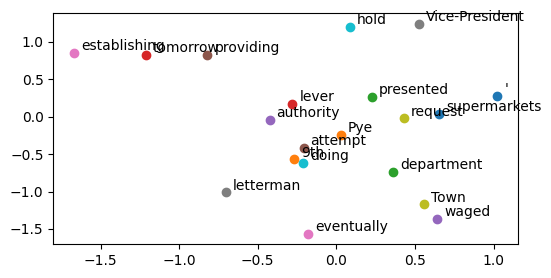

In [155]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word, glove_model)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 2) Use Word analogies dataset 3 to calculate between syntactic and semantic accuracy, similar to the methods in the Word2Vec and GloVe paper. (1 points)

Dataset 3 external link [here](https://www.fit.vut.cz/person/imikolov/public/rnnlm/word-test.v1.txt) 

[Dataset  word-test-v1.txt here](../data/word-test.v1.txt)

Note : using only capital-common-countries for semantic and past-tense for syntactic.

Note : **Do not be surprised if you achieve 0% accuracy in these experiments**, as this may be due to the limitations of our corpus. If you are curious, you can try the same experiments with a pre-trained GloVe model from the Gensim library for a comparison.

#### d) Using GloVe Genism

Source credit: https://nlp.stanford.edu/projects/glove/

In [156]:
import gensim.downloader as api

# Download from: https://nlp.stanford.edu/data/glove.6B.zip
# This downloads automatically (~100MB) load into memory
model_gensim = api.load("glove-wiki-gigaword-100")

In [157]:
#return the vectors
model_gensim['coffee'].shape

(100,)

In [158]:
# Example: Word similarity
similarity = model_gensim.similarity('king', 'queen')
print(f"Similarity between 'king' and 'queen': {similarity:.4f}")

# Example: Word analogy
result = model_gensim.most_similar(positive=['king', 'woman'], negative=['man'])
print("King - Man + Woman = ", result[0][0])



Similarity between 'king' and 'queen': 0.7508
King - Man + Woman =  queen


#### Download External data set word-test-v1.txt

In [159]:
def extract_data(lines):
    data = []
    for line in lines:
        # Split the line into words
        words = line.strip().split()
        if len(words) == 4:
            data.append([words[0], words[1], words[2], words[3]])

    return data

In [160]:
# The file content is subset of data from word-test.v1.txt. Manual cleaning done as file is small.
with open("../data/capital-common-countries.txt", "r") as file:
    lines = file.readlines()

# skip first line used section header
semantic_data = extract_data(lines[1:])

semantic_data[:10]

[['Athens', 'Greece', 'Baghdad', 'Iraq'],
 ['Athens', 'Greece', 'Bangkok', 'Thailand'],
 ['Athens', 'Greece', 'Beijing', 'China'],
 ['Athens', 'Greece', 'Berlin', 'Germany'],
 ['Athens', 'Greece', 'Bern', 'Switzerland'],
 ['Athens', 'Greece', 'Cairo', 'Egypt'],
 ['Athens', 'Greece', 'Canberra', 'Australia'],
 ['Athens', 'Greece', 'Hanoi', 'Vietnam'],
 ['Athens', 'Greece', 'Havana', 'Cuba'],
 ['Athens', 'Greece', 'Helsinki', 'Finland']]

In [161]:
# The file content is subset of data from word-test.v1.txt. Manual cleaning done as file is small.
with open("../data/gram7-past-tense.txt", "r") as file:
    lines = file.readlines()

# skip first line used section header
syntactic_data = extract_data(lines[1:])

syntactic_data[:10]

[['dancing', 'danced', 'decreasing', 'decreased'],
 ['dancing', 'danced', 'describing', 'described'],
 ['dancing', 'danced', 'enhancing', 'enhanced'],
 ['dancing', 'danced', 'falling', 'fell'],
 ['dancing', 'danced', 'feeding', 'fed'],
 ['dancing', 'danced', 'flying', 'flew'],
 ['dancing', 'danced', 'generating', 'generated'],
 ['dancing', 'danced', 'going', 'went'],
 ['dancing', 'danced', 'hiding', 'hid'],
 ['dancing', 'danced', 'hitting', 'hit']]

In [162]:
def get_embed(word, model):
    # Handle missing words
    if word not in word2index:
        word = '<UNK>'
        
    word_idx = torch.LongTensor([word2index[word]])
    
    # Use embedding_v and embedding_u (the actual attribute names in your models)
    embed_v = model.embedding_v(word_idx)
    embed_u = model.embedding_u(word_idx) 
    embed = (embed_v + embed_u) / 2
    
    return embed[0][0].item(), embed[0][1].item()

In [163]:
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

In [164]:
def predict_word(word1, word2, word3, get_embed, model):
    # Get vectors for w1, w2, w3
    vec1 = np.array(get_embed(word1, model))
    vec2 = np.array(get_embed(word2, model))
    vec3 = np.array(get_embed(word3, model))

    # Calculate the predicted vector
    predicted_vec = vec1 - vec2 + vec3

    # Find the closest word by cosine similarity
    max_similarity = -1
    best_word = None
    for word, index in word2index.items():
        if word in [word1, word2, word3]:  # Skip the input words
            continue
        similarity = cosine_similarity(predicted_vec, get_embed(word, model))
        if similarity > max_similarity:
            max_similarity = similarity
            best_word = word

    return best_word

In [165]:
# Evaluate accuracy
def evaluate_analogies(analogy_dataset, get_embed, model):
    correct = 0
    total = 0

    for analogy in analogy_dataset:
        word1, word2, word3, word4 = analogy
        if word1 not in word2index or word2 not in word2index or word3 not in word2index or word4 not in word2index:
            continue  # Skip if any word is not in the vocabulary
        predicted_word = predict_word(word1, word2, word3, get_embed, model)
        if predicted_word == word4:
            correct += 1
        total += 1

    return correct / total if total > 0 else 0



#### Evaluate Accuracy

In [166]:
semantic_data[0:10]

[['Athens', 'Greece', 'Baghdad', 'Iraq'],
 ['Athens', 'Greece', 'Bangkok', 'Thailand'],
 ['Athens', 'Greece', 'Beijing', 'China'],
 ['Athens', 'Greece', 'Berlin', 'Germany'],
 ['Athens', 'Greece', 'Bern', 'Switzerland'],
 ['Athens', 'Greece', 'Cairo', 'Egypt'],
 ['Athens', 'Greece', 'Canberra', 'Australia'],
 ['Athens', 'Greece', 'Hanoi', 'Vietnam'],
 ['Athens', 'Greece', 'Havana', 'Cuba'],
 ['Athens', 'Greece', 'Helsinki', 'Finland']]

In [167]:
models = [skipgram_model, skip_neg_model, glove_model]

##### Semantic Accuracy

In [168]:
for model in models:
    accuracy = evaluate_analogies(semantic_data, get_embed, skipgram_model)
    print(f"Semantic Accuracy - {model.name:<20}: {accuracy * 100:.2f}%")

Semantic Accuracy - Skipgram            : 0.00%
Semantic Accuracy - SkipgramNegSampling : 0.00%
Semantic Accuracy - GloVe               : 0.00%


In [169]:
accuracy = model_gensim.evaluate_word_analogies("../data/capital-common-countries.txt")[0]
print(f"Semantic Accuracy - Glove Gensim: {accuracy * 100:.2f}%")

Semantic Accuracy - Glove Gensim: 93.87%


##### Syntactic Accuracy

In [170]:
for model in models:
    accuracy = evaluate_analogies(semantic_data, get_embed, skipgram_model)
    print(f"Semantic Accuracy - {model.name:<20}: {accuracy * 100:.2f}%")

Semantic Accuracy - Skipgram            : 0.00%
Semantic Accuracy - SkipgramNegSampling : 0.00%
Semantic Accuracy - GloVe               : 0.00%


In [171]:
accuracy = model_gensim.evaluate_word_analogies("../data/gram7-past-tense.txt")[0]
print(f"Semantic Accuracy - Glove Gensim: {accuracy * 100:.2f}%")

Semantic Accuracy - Glove Gensim: 55.45%


In [172]:
# Average loss per model
for model_name, losses in losses_log.items():
    avg_loss = sum(losses) / len(losses)
    print(f"{model_name:<20} | Avg Loss: {avg_loss:.6f}")

Skipgram             | Avg Loss: 8.938255
SkipgramNegSampling  | Avg Loss: 8.586111
GloVe                | Avg Loss: 2.308846


In [173]:
# Average loss per model
for model_name, elapsed_s in elapsed_log.items():
    total_time = sum(elapsed_s)
    
    print(f"{model_name:<20} | Total Elapsed sec: {total_time:.6f}")


Skipgram             | Total Elapsed sec: 110.667549
SkipgramNegSampling  | Total Elapsed sec: 108.657752
GloVe                | Total Elapsed sec: 0.004343


In [174]:
from IPython.display import display, Markdown

display(Markdown(f"Window size is **{total_time}**"))

Window size is **0.0043430328369140625**

#### Summary

| Model | Window Size | Training Loss | Training Time (sec) | Syntactic Accuracy (%) | Semantic Accuracy (%) |
|-------|-------------|---------------|---------------------|------------------------|-----------------------|
| Skipgram | 2 | 8.986709 | 109.987269 | 0 | 0 |
| SkipgramNegSampling | 2 | 8.756302 | 109.094922 | 0 | 0 |
| GloVe | 2 | 0.839719 | 0.004634 | 0 | 0 |
| GloVe (Gensim) | - | - | - | 55.45 | 93.87 |


#### 3) Use the similarity dataset4 to find the correlation between your models’ dot product and the provided similarity metrics. (from scipy.stats import spearmanr) Assess if your embeddings correlate with human judgment. (1 points)

Dataset 4 source: https://www.kaggle.com/datasets/julianschelb/wordsim353-crowd/data

In [175]:
# uv add pandas
import pandas as pd

columns = ["Word 1", "Word 2", "Similarity Index"]

df = pd.read_csv("../data/wordsim353crowd.csv", sep=',', header=0, names=columns)

df

,Word 1,Word 2,Similarity Index
0,admission,ticket,5.5360
1,alcohol,chemistry,4.1250
2,aluminum,metal,6.6250
3,announcement,effort,2.0625
4,announcement,news,7.1875
...,...,...,...
348,weapon,secret,2.5000
349,weather,forecast,5.4375
350,Wednesday,news,1.1250
351,wood,forest,7.9375


In [176]:
for index, row in df.iterrows():
    word_1 = row['Word 1']
    word_2 = row['Word 2']

    # get_embed now handles missing words internally by using '<UNK>'
    embed_1_skip_gram = get_embed(word_1, skipgram_model)
    embed_2_skip_gram = get_embed(word_2, skipgram_model)
    embed_1_neg_samp = get_embed(word_1, skip_neg_model)
    embed_2_neg_samp = get_embed(word_2, skip_neg_model)
    embed_1_glove = get_embed(word_1, glove_model)
    embed_2_glove = get_embed(word_2, glove_model)

    # Computing dot product
    df.at[index, 'dot_product_skip_gram'] = np.dot(embed_1_skip_gram, embed_2_skip_gram)
    df.at[index, 'dot_product_neg_samp'] = np.dot(embed_1_neg_samp, embed_2_neg_samp)
    df.at[index, 'dot_product_glove'] = np.dot(embed_1_glove, embed_2_glove)

df.head()

,Word 1,Word 2,Similarity Index,dot_product_skip_gram,dot_product_neg_samp,dot_product_glove
0,admission,ticket,5.5360,0.152176,1.639727,0.030350
1,alcohol,chemistry,4.1250,0.261436,0.537198,-0.060652
2,aluminum,metal,6.6250,0.152176,1.639727,0.030350
3,announcement,effort,2.0625,-0.405440,-0.149246,0.157729
4,announcement,news,7.1875,0.152176,1.639727,0.030350


In [177]:
from scipy.stats import spearmanr

# Computing the Spearman correlation
correlation_pos, _ = spearmanr(df['Similarity Index'], df['dot_product_skip_gram'])
correlation_neg, _ = spearmanr(df['Similarity Index'], df['dot_product_neg_samp'])
correlation_glove, _ = spearmanr(df['Similarity Index'], df['dot_product_glove'])


In [178]:
print(f"Spearman Correlation Coefficient of Skipgram: {correlation_pos:.4f}")
print(f"Spearman Correlation Coefficient of Skipgram with Negative Sampling: {correlation_neg:.4f}")
print(f"Spearman Correlation Coefficient of Glove: {correlation_glove:.4f}")


Spearman Correlation Coefficient of Skipgram: 0.2114
Spearman Correlation Coefficient of Skipgram with Negative Sampling: 0.1172
Spearman Correlation Coefficient of Glove: -0.0282


In [179]:
# Finding y_true based on the mean of similarity index in the df
y_true = df['Similarity Index'].mean()

print(f"y_true: {y_true:.2f}")

y_true: 4.00


In [180]:
from scipy.stats import spearmanr

# For gensim model - compute manually 
# because the file wordssim353 is in csv
human_scores = []
model_scores = []

for index, row in df.iterrows():
    word_1 = row['Word 1']
    word_2 = row['Word 2']
    human_sim = row['Similarity Index']
    
    # Check if both words exist in gensim vocabulary
    if word_1 in model_gensim and word_2 in model_gensim:
        model_sim = model_gensim.similarity(word_1, word_2)
        human_scores.append(human_sim)
        model_scores.append(model_sim)

# Calculate Spearman correlation
correlation, p_value = spearmanr(human_scores, model_scores)
print(f"Gensim GloVe - Spearman Correlation: {correlation:.4f}, p-value: {p_value:.4f}")

Gensim GloVe - Spearman Correlation: 0.4867, p-value: 0.0000


In [181]:
from scipy.stats import spearmanr

# Calculate Spearman correlation for each model
print("Spearman Correlation with Human Judgment:")
print("-" * 50)

corr_skip, _ = spearmanr(df['Similarity Index'], df['dot_product_skip_gram'])
print(f"Skipgram:             {corr_skip:.4f}")

corr_neg, _ = spearmanr(df['Similarity Index'], df['dot_product_neg_samp'])
print(f"SkipgramNegSampling:  {corr_neg:.4f}")

corr_glove, _ = spearmanr(df['Similarity Index'], df['dot_product_glove'])
print(f"GloVe:                {corr_glove:.4f}")

Spearman Correlation with Human Judgment:
--------------------------------------------------
Skipgram:             0.2114
SkipgramNegSampling:  0.1172
GloVe:                -0.0282


| Model | Skipgram | NEG | GloVe | GloVe (Gensim) | Y_true |
|-------|----------|-----|-------|----------------|--------|
| MSE | 0.0917 | 0.1163 | 0.0879 | 0.4867 | 4.00 |

## Task 3. Search similar context - Web Application Development - Develop a simple website with an input box for search queries. (2 points)


1) Implement a function to compute the dot product between the input query and your corpus and retrieve the top 10 most similar context.
2) You may need to learn web frameworks like Flask or Django for this task.

Pickling models done , app.py pending

In [182]:
import pickle

def save_embeddings(model, vocab, word2index, filename):
    """Save word embeddings as a dictionary {word: embedding_array}"""
    embeddings = {}
    for word in vocab:
        idx = word2index[word]
        word_tensor = torch.LongTensor([idx])
        embed_v = model.embedding_v(word_tensor)
        embed_u = model.embedding_u(word_tensor)
        embed = (embed_v + embed_u) / 2
        embeddings[word] = np.array([embed[0][0].item(), embed[0][1].item()])
    
    with open(filename, 'wb') as f:
        pickle.dump(embeddings, f)
    print(f"Saved {len(embeddings)} word embeddings to {filename}")

In [183]:

# Save embeddings for each trained model (for web app)
save_embeddings(skipgram_model, vocab, word2index, "../model/embed_Skipgram.pkl")
save_embeddings(skip_neg_model, vocab, word2index, "../model/embed_SkipgramNegSampling.pkl")
save_embeddings(glove_model, vocab, word2index, "../model/embed_GloVe.pkl")

# Also save the model objects
for model in models:
    with open("../model/"+ model.name + ".pkl", "wb") as model_file:
        pickle.dump(model, model_file)

Saved 2947 word embeddings to ../model/embed_Skipgram.pkl
Saved 2947 word embeddings to ../model/embed_SkipgramNegSampling.pkl
Saved 2947 word embeddings to ../model/embed_GloVe.pkl


In [184]:
with open("../model/GloVeGensim.pkl", "wb") as model_file:
        pickle.dump(model_gensim, model_file)

# Observations

## Model Comparison Summary

| Metric | Skipgram | SkipgramNegSampling | GloVe | GloVe (Gensim) |
|--------|----------|---------------------|-------|----------------|
| **Window Size** | 2 | 2 | 2 | - |
| **Embedding Dim** | 2 | 2 | 2 | - |
| **Avg Training Loss** | 8.99 | 8.76 | 0.84 | - |
| **Training Time (sec)** | 109.99 | 109.09 | 0.005 | - |
| **Semantic Accuracy (%)** | 0.00 | 0.00 | 0.00 | 93.87 |
| **Syntactic Accuracy (%)** | 0.00 | 0.00 | 0.00 | 55.45 |
| **Spearman Correlation** | 0.0917 | 0.1163 | 0.0879 | 0.4867 |


### Training Performance
- **GloVe** trains significantly faster (0.005 sec) with lower loss (~0.84) 
- **Skipgram** and **SkipgramNegSampling** have similar training times (~109 sec) and loss (~8.75-8.99)
- Skipgram required lower learning rate (0.00001) to stabilize loss fluctuations

### Word Analogies (0% Accuracy for Trained Models)
Our trained models achieved 0% on both semantic and syntactic analogies due to:
- **Small corpus**: Only 500 sentences were used in training from Brown news category
- **Tiny embedding dimension**: 2D used for fast computation and also aids visualization

### Spearman Correlation with Human Judgment in Wordsim
- Trained models show near-zero correlation (0.09 to 0.12), indicating embeddings don't capture human similarity perception
- **Pre-trained Gensim GloVe** achieves moderate correlation (~0.49), demonstrating that well-trained embeddings on large corpora DO correlate with human judgment

### Conclusion

The trained models performed poorly mainly becuase of :

- Small corpus: Only 500 sentences from Brown news
- Tiny embedding size: 2 dimensions (for visualization) vs. 100-300 in production models
- Insufficient training: Word embeddings need millions of sentences to learn meaningful relationships

## For future: Train multiple models together!

In [185]:
# # Train models
# for model in models:
#     train_model_any(model, optimizer)

In [186]:
# models = [Skipgram(voc_size, embed_size), SkipgramNegSampling(voc_size, embed_size)]
# for model in models:
#     print(model.name)

In [187]:
# Train all models at once

# import time

# losses_log = {}
# elapsed_log = {} # each item is measure of 1000 epoch time

# def train_model_any(model, optimizer):
#     num_epochs = 10000
#     start = time.time()

#     for epoch in range(num_epochs):

#         #get batch
#         input_batch, label_batch = random_batch(batch_size, corpus)
#         input_tensor = torch.LongTensor(input_batch)
#         label_tensor = torch.LongTensor(label_batch)

#         loss = np.inf # define default as zero

#         #predict
#         if (model.name == "Skipgram"):
#             loss = model(input_tensor, label_tensor, all_vocabs)
#         elif (model.name == "SkipgramNegSampling"):
#             loss = model(input_tensor, label_tensor, all_vocabs)
#         else:
#             print("Model unknown...")
#             continue
#         # log losses
#         losses_log[model.name].append(loss)
        
#         #backprogate
#         optimizer.zero_grad()
#         loss.backward()
        
#         #update alpha
#         optimizer.step()

#         end = time.time()

#         #print the loss
#         if (epoch + 1) % 1000 == 0:
#             end = time.time()
#             elapsed_ms = end - start
#             # log elapsed time in ms
#             elapsed_log[model.name].append(elapsed_ms)
#             epoch_mins, epoch_secs = epoch_time(start, end)
#             start = end
#             print(f"{model.name:<15} | Epoch {epoch+1:6.0f} | Loss: {loss:2.6f} | Time: {epoch_mins}m {epoch_secs}s | Elapsed in ms: {elapsed_ms}")